## Recurrent Neural Networks (RNNs) for the Regression Problem

In this notebook, we build a Recurrent Neural Networks (RNNs) using GloVe word embeddings, to predict the __log_votes__ field of our review dataset.

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)

__Important note:__ One big distinction betweeen the regular neural networks and RNNs is that RNNs work with sequential data. In our case, RNNs will help us with the text field. If we also want to consider other fields such as time, rating, verified, etc. , we need to use the regular neural networks and connect it to the RNN network.

In [1]:
import re
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn, rnn

### 1. Reading the dataset

Let's read the dataset below and fill-in the reviewText field. We will use this field as input to our ML model.

In [2]:
import pandas as pd

df = pd.read_csv('../../DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv')

Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [3]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


### 2. Exploratory Data Analysis and Missing Value Imputation

Let's look at the range and distribution of log_votes

In [4]:
df["log_votes"].min()

0.0

In [5]:
df["log_votes"].max()

7.799753318287247

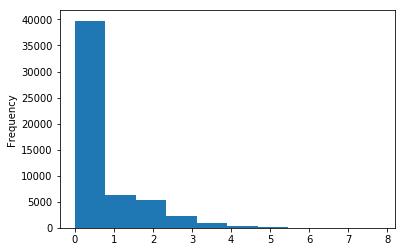

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [7]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


We will only consider the reviewText field. Let's fill-in the missing values for that below. We will just use the placeholder "Missing" here.

In [8]:
df["reviewText"].fillna("Missing", inplace=True)

### 3. Text processing-cleaning
Next, we will clean the text. We will remove leading/train white space, extra space and html tags. Recurrent neural networks usually __DON'T__ need text processing work further than simple text cleaning. Stemming and lemmatization can introduce some errors that will cause our model to skip those words completely. 

In [9]:
# Some string preprocessing
def clean_str(text):
    text = text.lower().strip() # Remove leading/trailing whitespace
    text = re.sub('\s+', ' ', text) # Remove extra space and tabs
    text = re.compile('<.*?>').sub('', text) # Remove HTML tags/markups:
    return text

Next, we are going to process all of the words in the reviews, count the number of occurences of each word, and then index the words in descending order with respect to how many times this occur. This is a necessary input to help us encode the words in the reviews so that they can be understood by a machine.

In [10]:
#This creates a dictionary of the words and their counts

word_counter = Counter()
def create_count(sentiments):
    for line in sentiments:
        for word in (clean_str(line)).split():
            if word not in word_counter.keys():               
                word_counter[word] = 1
            else:
                word_counter[word] += 1

#This assigns a unique a number for each word (sorted by descending order 
#based on the frequency of occurrence)and returns a word_dict

def create_word_index():
    idx = 1
    word_dict = {}
    for word in word_counter.most_common():
        word_dict[word[0]] = idx
        idx+=1
    return word_dict
    
#Here we combine all of the reviews into one dataset and create a word
#dictionary using this entire dataset
create_count(df["reviewText"].tolist())
word_dict = create_word_index()

#This creates a reverse index from a number to the word 
idx2word = {v: k for k, v in word_dict.items()}

Next we create a set of helper functions that (1) encode words into a sequence of numbers, (2) decode a sequence of numbers back into words, and (3) truncate and pad the input data to ensure they are of equal length and thereby enable easier processing.  

In [11]:
#This helper function creates a encoded sentences by assigning the unique 
#id from word_dict to the words in the input text
def encoded_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = []
        for word in (clean_str(line)).split():
            if word in word_dict:
                output_line.append(word_dict[word])
        output_string.append(output_line)
    return output_string

#This helper function decodes encoded sentences
def decode_sentences(input_file,word_dict):
    output_string = []
    for line in input_file:
        output_line = ''
        for idx in line:
            output_line += idx2word[idx] + ' '
        output_string.append(output_line)
    return output_string

#This helper function pads the sequences to maxlen.
#If the sentence is greater than maxlen, it truncates the sentence.
#If the sentence is less than 50, it pads with value 0.
def pad_sequences(sentences,maxlen=50,value=0):
    padded_sentences = []
    for sen in sentences:
        new_sentence = []
        if(len(sen) > maxlen):
            new_sentence = sen[:maxlen]
            padded_sentences.append(new_sentence)
        else:
            num_padding = maxlen - len(sen)
            new_sentence = np.append(sen,[value] * num_padding)
            padded_sentences.append(new_sentence)
    return padded_sentences

Next we are going to encode all of the reviewText using the word dictionary created. In addition, we are going to cap the size of the tracked vocabulary size - meaning any word that is outside of the tracked range will be encoded with the last position. This is performance versus accuracy consideration - a larger tracked vocabulary will lead to more accurary but will have performance considerations because it requires a longer training process.

In [12]:
# Let's encode sentences
encoded_texts = encoded_sentences(df["reviewText"].tolist(), word_dict)

#Here we set the total num of words to be tracked
vocab_size = 5000 

#Any word outside of the tracked range will be encoded with last position.
t_data = [np.array([i if i<(vocab_size-1) else (vocab_size-1) for i in s]) for s in encoded_texts]
all_labels = df["log_votes"].tolist()

In [13]:
# Let's print the first sentence
# We have 4999 for words outside range of 5000 words

t_data[0]

array([1095,   15,   10,   42,  751,  449,    4,  102,  101,  117, 1147,
         15,    5, 4999, 4999])

### 4. Using pre-trained GloVe Word Embeddings:

In this example, we will use GloVe word vectors. The following code shows how to get the word vectors and create an embedding dictionary with them. The dictionary maps the words to their word vectors. The file is downloaded from here: https://nlp.stanford.edu/projects/glove/

In [14]:
# Download the zip file - WARNING: THIS TAKES A WHILE!
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-02-12 03:44:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-12 03:44:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-12 03:44:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [15]:
# Unziping
! unzip glove.6B.zip

# Deleting the zip file
! rm glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Below, we first create a mapper for the word vectors (word->vector) with the __load_glove_index()__ function. Later, __create_emb()__ creates an embedding matrix. Each row corresponds to a word. For our vocabulary size of 5000 and 300 word vector dimension, this gives a matrix of 5000 rows and  300 columns.

In [16]:
# We downloaded the 300 dimension word vectors
num_embed = 300 

def load_glove_index(loc):
    f = open(loc, encoding="utf8")
    embeddings_index = {}
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

def create_emb():
    embedding_matrix = np.zeros((vocab_size, num_embed))
    for word, i in word_dict.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    embedding_matrix = nd.array(embedding_matrix)
    return embedding_matrix

embeddings_index = load_glove_index('glove.6B.300d.txt')
embedding_matrix = create_emb()

In [17]:
embedding_matrix.shape

(5000, 300)

Next we prepare the review texts to be fed into the deep learning model by (1) Reserving 15% of the dataset as a validation dataset, (2) padding and truncating the data to the length of 50 words, and (3) converting the encoded text into into MXNet's NDArray format.

In [18]:
# This separates 15% of the entire dataset into test dataset.
X_train, X_test, y_train, y_test = train_test_split(t_data, all_labels, test_size=0.15, random_state=42)

In [19]:
#This set the max word length of each review text
seq_len = 50

#Below we pad the reviews and convert them to MXNet's NDArray format
X_train = nd.array(pad_sequences(X_train, maxlen=seq_len, value=0))
y_train = nd.array(y_train)
X_test = nd.array(pad_sequences(X_test, maxlen=seq_len, value=0))
y_test = nd.array(y_test)

We will set our parameters below

In [20]:
num_hidden = 64
learning_rate = .001
epochs = 10
batch_size = 16

In [21]:
train_arraydataset = mx.gluon.data.ArrayDataset(X_train, y_train)
train_loader = mx.gluon.data.DataLoader(train_arraydataset, batch_size=batch_size, shuffle=False, last_batch='keep')

We will be using an RNN model with 64 hidden units. Let's use the Sequential mode

In [22]:
context = mx.cpu()

model = mx.gluon.nn.Sequential()

model = nn.Sequential()
model.add(mx.gluon.nn.Embedding(vocab_size, num_embed),        # Embedding layer
          mx.gluon.rnn.RNN(num_hidden, layout = 'NTC'),        # Recurrent layer
          mx.gluon.nn.Dense(1, activation='relu')              # Output layer
         )

model.collect_params().initialize(mx.init.Xavier(), ctx=context)
model[0].weight.set_data(embedding_matrix.as_in_context(context))
model[0].collect_params().setattr('grad_req', 'null')

Before we execute the training loop, we need to define a function that will calculate the accurary metrics for the model.

Let's start the training process below. We will print Mean Squared Error after each epoch.

In [23]:
def evaluate_mse(data_iterator, net, ctx=mx.cpu()):
    metric = mx.metric.MSE()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1, data2]
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        metric.update([label], [output])
    return metric.get()[1]

def evaluate_accuracy(data_iterator, net, ctx=mx.cpu()):
    metric = mx.metric.MSE()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1, data2]
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        metric.update([label], [output])
    return metric.get()[1]



In [26]:
# Setting our trainer
trainer = gluon.Trainer(model.collect_params(), 'sgd',
                        {'learning_rate': learning_rate})

# We will use L2 loss (regression)
l2_loss = gluon.loss.L2Loss()    

for epoch in range(epochs):
    training_loss = 0
    train_predictions = nd.array([])
    # Training loop, train the network
    for idx,(data,target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = model(data)
            
            L = l2_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            #print(idx, training_loss)
            if len(train_predictions)>0:
                train_predictions = nd.concat(train_predictions, output, dim=0)
            else:
                train_predictions = output
            
            L.backward()
        trainer.step(data.shape[0])
    
    val_predictions = model(X_test)
    val_loss = nd.sum(l2_loss(val_predictions, y_test)).asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(X_train)
    val_loss = val_loss / len(val_predictions)
      
    print("Epoch %s. Train_loss (mse) %s Validation_loss (mse) %s" % (epoch, training_loss, val_loss))

Epoch 0. Train_loss (mse) 0.36823840090871496 Validation_loss (mse) 0.3981466027462121
Epoch 1. Train_loss (mse) 0.36229212773228714 Validation_loss (mse) 0.396168974905303
Epoch 2. Train_loss (mse) 0.3576843620143472 Validation_loss (mse) 0.3949965672348485
Epoch 3. Train_loss (mse) 0.3538548159267813 Validation_loss (mse) 0.3942821081912879
Epoch 4. Train_loss (mse) 0.35053092534210595 Validation_loss (mse) 0.3937601503314394
Epoch 5. Train_loss (mse) 0.34753742843069496 Validation_loss (mse) 0.3934677142518939
Epoch 6. Train_loss (mse) 0.34479565669317297 Validation_loss (mse) 0.39322253787878786
Epoch 7. Train_loss (mse) 0.34222613111791766 Validation_loss (mse) 0.39326376065340907
Epoch 8. Train_loss (mse) 0.33981642869003315 Validation_loss (mse) 0.39332572798295456
Epoch 9. Train_loss (mse) 0.337520366230113 Validation_loss (mse) 0.39346851325757576


In [27]:
# Deleting notebook artifacts
! rm glove.6B.300d.txt
! rm glove.6B.200d.txt
! rm glove.6B.100d.txt
! rm glove.6B.50d.txt


rm: cannot remove ‘glove.6B.100d.txt’: No such file or directory
